# Visualization of jet-induced flow in JETSCAPE

## <font color="Blue">0. Read output from MUSIC (hydro)</font>

In [9]:
%matplotlib notebook

from numpy import *
from os import path
home = path.expanduser("~")

from matplotlib import animation
import matplotlib.pyplot as plt

# define format for the plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [6., 4.5]
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['font.size'] = 15
mpl.rcParams['savefig.format'] = "pdf"


working_path = path.join(home, "JETSCAPE")

/home/jetscape-user
/home/jetscape-user
/home/jetscape-user/JETSCAPE


In [10]:
# define the contour levels
levels = linspace( -10.5, 10.5, 201)

# define a custmized color map
colors1 = array([[1, 1, 1, 1]])
colors2 = plt.cm.jet(linspace(0., 1, 10))
colors = vstack((colors1, colors2))
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)

### <font color="Red">*Change the following line to your result folder</font>

In [11]:
# change the following line to your result folder
TestResultFolder = "build"

In [15]:
# load 1st hydrodynamic evolution data (without jet-induced flow)
data_bg = fromfile(
    path.join(working_path, TestResultFolder,
              "evolution_all_xyeta_MUSIC_1.dat"), dtype=float32)

# load 2nd hydrodynamic evolution data (with jet-induced flow)
data_src = fromfile(
    path.join(working_path, TestResultFolder,
              "evolution_all_xyeta_MUSIC_2.dat"), dtype=float32)

# read header about the grid information
header = data_bg[0:16]

# read in data and reshape it to the correct form
data_bg = data_bg[16:].reshape(-1, int(header[-1]))
data_src = data_src[16:].reshape(-1, int(header[-1]))

# get the list for tau frame
tau_list = unique(data_bg[:, 0])
tau_list_src = unique(data_src[:, 0])

# find shorter lifetime of QGP
if len(tau_list) > len(tau_list_src):
    tau_list = tau_list_src
    
ntau = len(tau_list)
tau0= header[0]; dtau = header[1];
tau_list = array([tau0 + i*dtau for i in range(ntau)])
    

# define 3D grid in x, y, and eta_s (space-time rapidity)
neta = int(header[8])
eta_size = -2.*header[10]
deta = header[9]
eta = array([-eta_size/2.+i*deta for i in range(neta)])

nx = int(header[2])
x_size = 2.*abs(header[4])
dx = header[3]
x = array([-x_size/2.+i*dx for i in range(nx)])

ny = int(header[5])
y_size = 2.*abs(header[7])
dy = header[6]
y = array([-y_size/2.+i*dy for i in range(ny)])

# create 3D grids for energy density, temperature, and velocity

# Results with jet-induced flow
ed_src = zeros([ntau, neta, nx, ny])
T_src  = zeros([ntau, neta, nx, ny])
vx_src = zeros([ntau, neta, nx, ny])
vy_src = zeros([ntau, neta, nx, ny])

for itau in range(ntau):
    idx = (abs(data_src[:, 0] - itau) < 0.05)
    data_cut = data_src[idx, :]
    for igrid in range(len(data_cut[:, 0])):
        x_idx   = int(data_cut[igrid, 1] + 0.1)
        y_idx   = int(data_cut[igrid, 2] + 0.1)
        eta_idx = int(data_cut[igrid, 3] + 0.1)
        u0 = sqrt(1. + data_cut[igrid, 7]**2.
                  + data_cut[igrid, 8]**2. + data_cut[igrid, 9]**2)
           
        ed_src[itau, eta_idx, x_idx, y_idx] = data_cut[igrid, 4]
        T_src[itau, eta_idx, x_idx, y_idx]  = data_cut[igrid, 6]
        vx_src[itau, eta_idx, x_idx, y_idx] = data_cut[igrid, 7]/u0
        vy_src[itau, eta_idx, x_idx, y_idx] = data_cut[igrid, 8]/u0

# Results without jet-induced flow
ed_bg = zeros([ntau, neta, nx, ny])
T_bg  = zeros([ntau, neta, nx, ny])
vx_bg = zeros([ntau, neta, nx, ny])
vy_bg = zeros([ntau, neta, nx, ny])

for itau in range(ntau):
    idx = (abs(data_bg[:, 0] - itau) < 0.05)
    data_cut = data_bg[idx, :]
    for igrid in range(len(data_cut[:, 0])):
        x_idx   = int(data_cut[igrid, 1] + 0.1)
        y_idx   = int(data_cut[igrid, 2] + 0.1)
        eta_idx = int(data_cut[igrid, 3] + 0.1)
        u0 = sqrt(1. + data_cut[igrid, 7]**2.
                  + data_cut[igrid,8]**2. + data_cut[igrid, 9]**2)
           
        ed_bg[itau, eta_idx, x_idx, y_idx] = data_cut[igrid, 4]
        T_bg[itau, eta_idx, x_idx, y_idx]  = data_cut[igrid, 6]
        vx_bg[itau, eta_idx, x_idx, y_idx] = data_cut[igrid, 7]/u0
        vy_bg[itau, eta_idx, x_idx, y_idx] = data_cut[igrid, 8]/u0


# Difference
ed = zeros([ntau, neta, nx, ny])
T  = zeros([ntau, neta, nx, ny])
vx = zeros([ntau, neta, nx, ny])
vy = zeros([ntau, neta, nx, ny])

import itertools
for itau, ieta, ix, iy in itertools.product(range(ntau),range(neta),range(nx),range(ny)):
    if T_src[itau, ieta, ix, iy] > 0.0 and T_bg[itau, ieta, ix, iy] > 0.0:
        ed[itau, ieta, ix, iy]=ed_src[itau, ieta, ix, iy] - ed_bg[itau, ieta, ix, iy]
        T[itau, ieta, ix, iy]=1000*(T_src[itau, ieta, ix, iy] - T_bg[itau, ieta, ix, iy])
        vx[itau, ieta, ix, iy]=vx_src[itau, ieta, ix, iy] - vx_bg[itau, ieta, ix, iy]
        vy[itau, ieta, ix, iy]=vy_src[itau, ieta, ix, iy] - vy_bg[itau, ieta, ix, iy]                    
                    
# print out some useful information about the evolution file
print("Read in data completed.")
print("ntau = {0}, tau_min = {1:.2f} fm, tau_max = {2:.2f} fm, dtau = {3:.3f} fm".format(
                            ntau, tau_list[0], tau_list[-1], dtau))
print("nx = {0}, x_min = {1:.2f} fm, x_max = {2:.2f} fm, dx = {3:.2f} fm".format(
                            nx, x[0], x[-1], dx))
print("ny = {0}, y_min = {1:.2f} fm, y_max = {2:.2f} fm, dy = {3:.2f} fm".format(
                            ny, y[0], y[-1], dy))
print("neta = {0}, eta_min = {1:.2f} fm, eta_max = {2:.2f} fm, deta = {3:.2f}".format(
                            neta, eta[0], eta[-1], deta))

print(r"max delta T = ", amax(T)," MeV")
print(r"min delta T = ", amin(T)," MeV")

Read in data completed.
ntau = 126, tau_min = 0.50 fm, tau_max = 13.00 fm, dtau = 0.100 fm
nx = 100, x_min = -15.00 fm, x_max = 14.70 fm, dx = 0.30 fm
ny = 100, y_min = -15.00 fm, y_max = 14.70 fm, dy = 0.30 fm
neta = 1, eta_min = 0.00 fm, eta_max = 0.00 fm, deta = 0.10
max delta T =  7.275745272636414  MeV
min delta T =  -1.793786883354187  MeV


## <font color="Blue">1. Plot a 2D contour in the transverse plane</font>
### Distribution of temperature diffecence caused by the jet propagation ($\Delta T = T_{\mathrm{w/\,jet}}-T_{\mathrm{w/o\,jet}}$) in the transverse plane at $\tau=8.2$ fm/$c$.

<IPython.core.display.Javascript object>


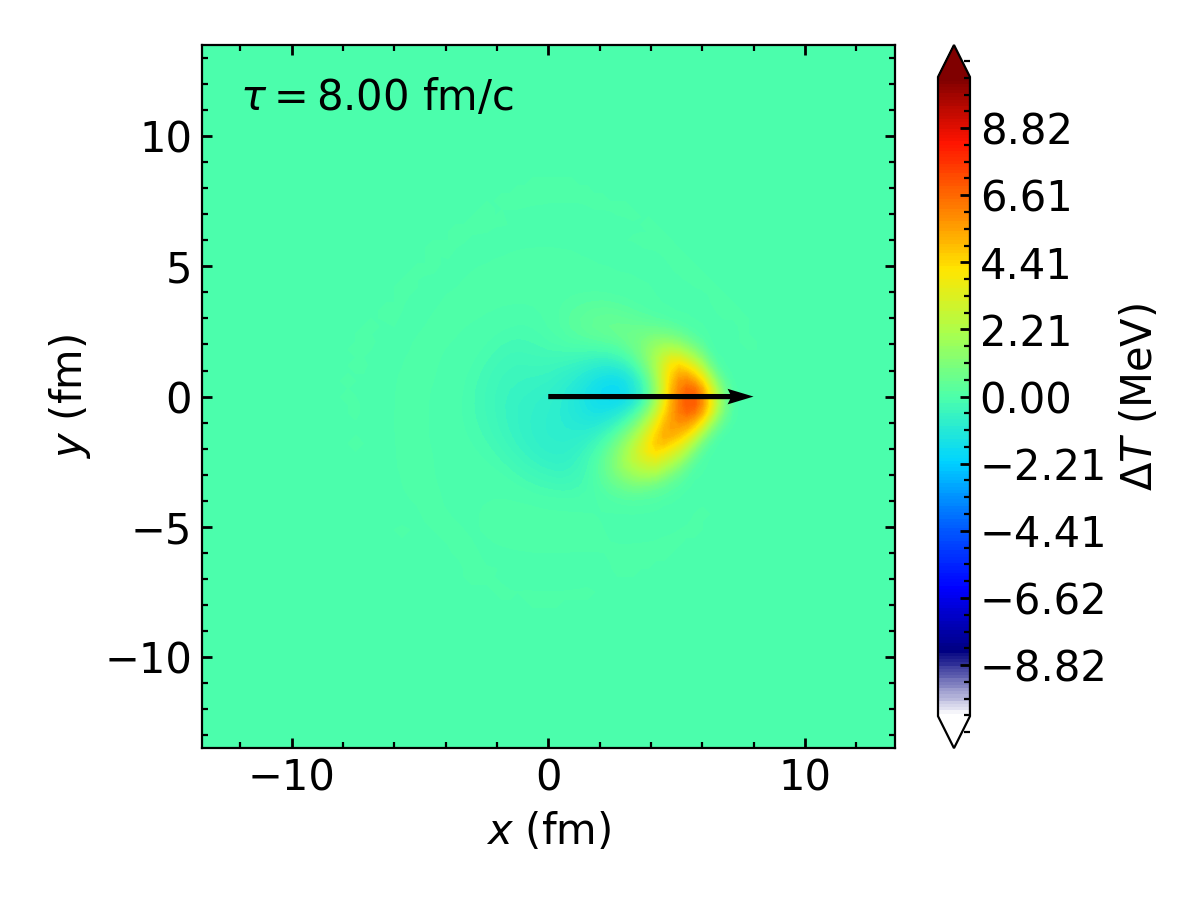

In [21]:
# make a 2D meshgrid in the transverse plane
X, Y = meshgrid(x, y)


# make the contour plot
fig = plt.figure()
i_tau = int(0.6*(ntau-1))
cont = plt.contourf(X, Y, T[i_tau, 0, :, :].transpose(), levels, cmap=my_cmap, extend='both')

cbar = fig.colorbar(cont)
cbar.set_label(r"$\Delta T$ (MeV)")

time_text = plt.text(-12, 11, r"$\tau = {0:4.2f}$ fm/c".format(tau_list[i_tau]))
plt.xlabel(r"$x$ (fm)")
plt.ylabel(r"$y$ (fm)")
plt.xlim([-13.5, 13.5])
plt.ylim([-13.5, 13.5])


plt.quiver(0, 0, tau_list[i_tau], 0, scale_units='xy', angles='xy', scale=1)

plt.tight_layout()
plt.savefig("MedRes_Temperature_Contour_XY")

## <font color="Blue">2. Plot a 2D contour in the $\tau$-$x$ plane</font>
### Distribution of temperature diffecence caused by the jet propagation ($\Delta T = T_{\mathrm{w/\,jet}}-T_{\mathrm{w/o\,jet}}$) in the $\tau$-$x$ plane at $y=0$.

<IPython.core.display.Javascript object>


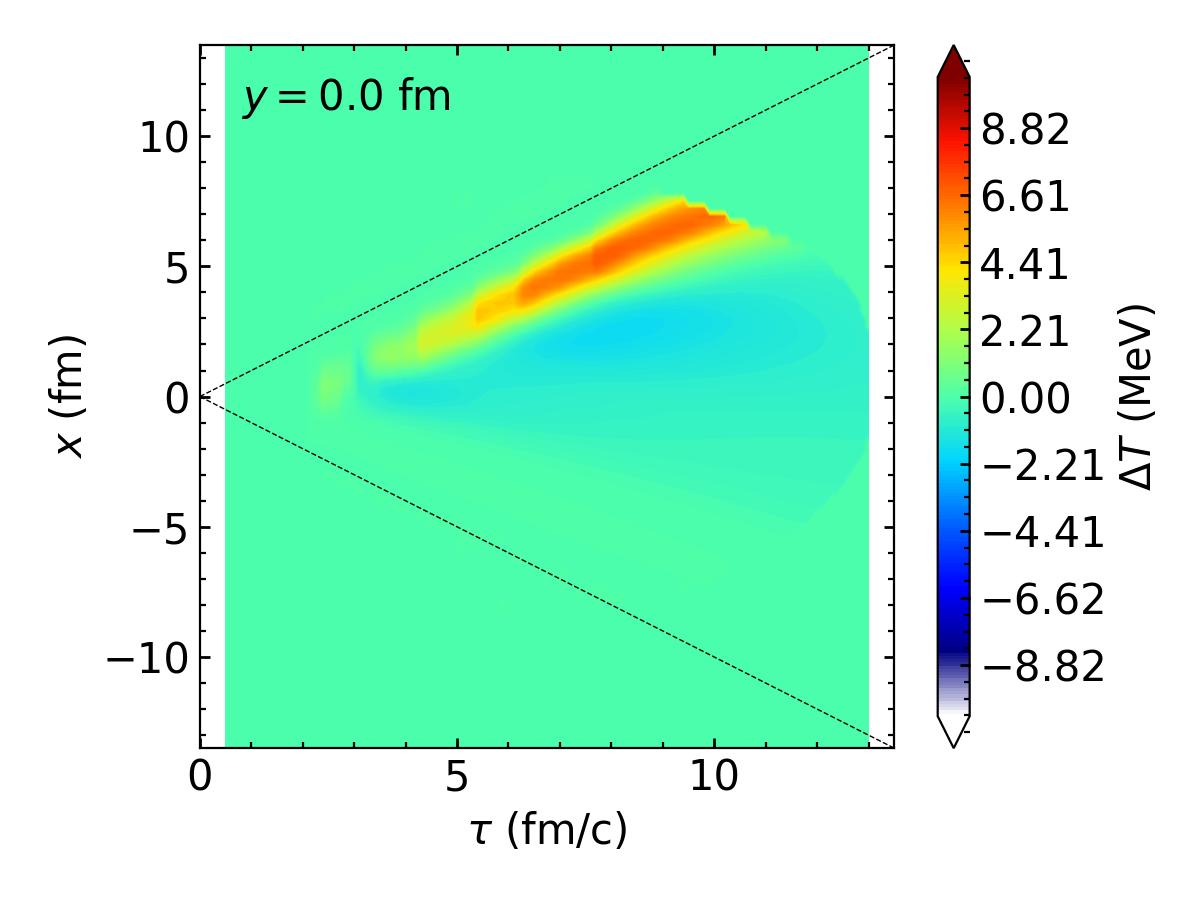

In [20]:
Tau, X = meshgrid(tau_list, x)

y_idx = int(ny/2)  # pick the central point in the y direction

fig = plt.figure()
cont = plt.contourf(Tau, X, T[:, 0, :, y_idx].transpose(), levels,
                    cmap=my_cmap, extend='both')
cbar = fig.colorbar(cont)
cbar.set_label(r"$\Delta T$ (MeV)")

plt.xlabel(r"$\tau$ (fm/c)")
plt.ylabel(r"$x$ (fm)")
plt.xlim([0, 13.5])
plt.ylim([-13.5, 13.5])
plt.text(0.8, 11, r'$y = {0:3.1f}$ fm'.format(y[y_idx]))

x_light = arange(0,100,2)
y_light = x_light
plt.plot(x_light,y_light,color='black',linestyle='dashed',linewidth=0.5)
y_light = -x_light
plt.plot(x_light,y_light,color='black',linestyle='dashed',linewidth=0.5)

plt.tight_layout()
plt.savefig("MedRes_Temperature_Contour_TauX")

Dashed lines show the borders of the ligt cone

## <font color="Blue">1. Generate a movie of 2D contour plot in the transverse plane</font>
### Distribution of temperature diffecence caused by the jet propagation ($\Delta T = T_{\mathrm{w/\,jet}}-T_{\mathrm{w/o\,jet}}$) in the transverse plane.

<IPython.core.display.Javascript object>


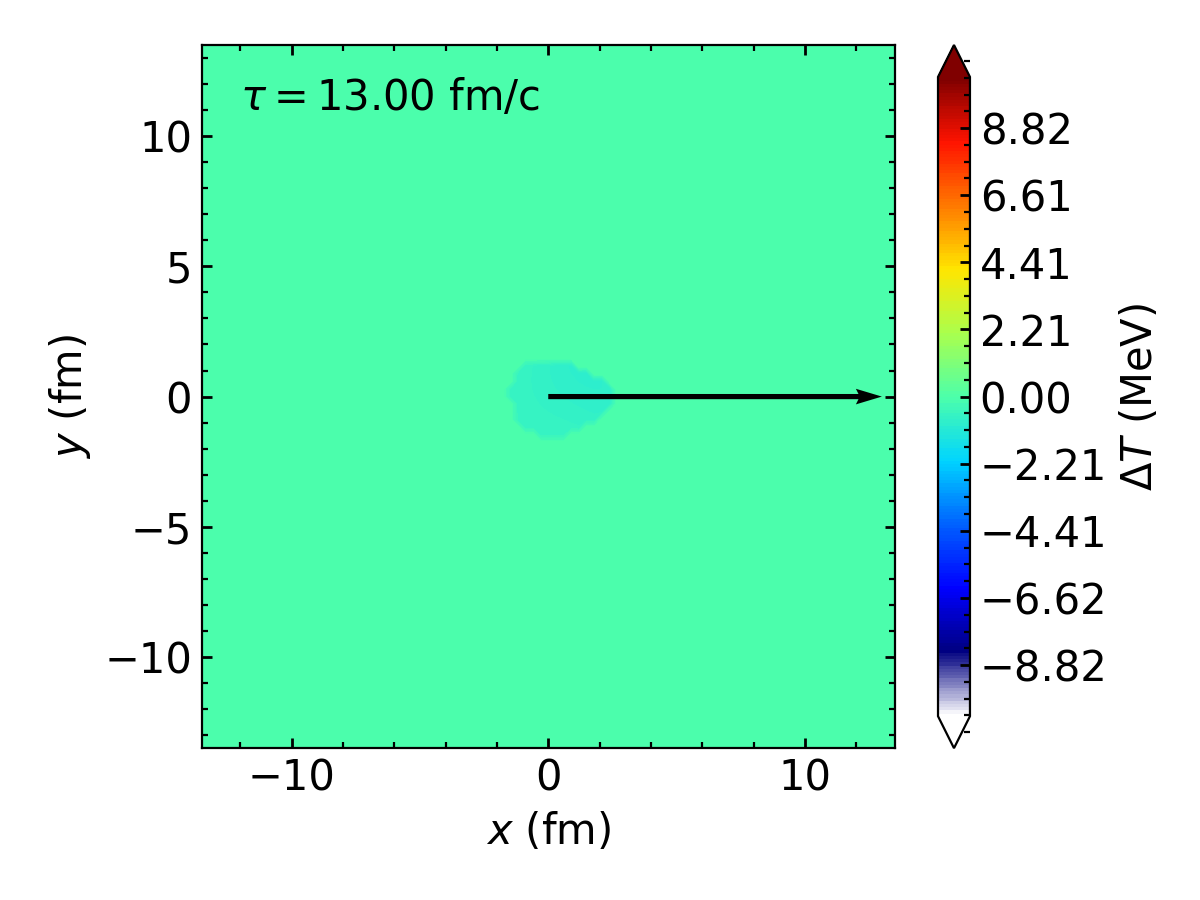

In [19]:
X, Y = meshgrid(x, y)

# first plot the first frame as a contour plot
fig = plt.figure()
cont = plt.contourf(X, Y, T[0, 0, :, :].transpose(), levels,
                    cmap=my_cmap, extend='both')
time_text = plt.text(-12, 11, r"$\tau = {0:4.2f}$ fm/c".format(tau_list[0]))
cbar = fig.colorbar(cont)
cbar.set_label(r"$\Delta T$ (MeV)")
plt.xlabel(r"$x$ (fm)")
plt.ylabel(r"$y$ (fm)")
plt.xlim([-13.5, 13.5])
plt.ylim([-13.5, 13.5])
plt.tight_layout()

# define animation function to update the contour at every time frame
def animate(i): 
    global cont, time_text
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    cont = plt.contourf(X, Y, T[i, 0, :, :].transpose(), levels, cmap=my_cmap, extend='both')
    plt.quiver(0, 0, tau_list[i], 0, scale_units='xy', angles='xy', scale=1)
    time_text.set_text(r"$\tau = {0:4.2f}$ fm/c".format(tau_list[i]))
    return cont, time_text

# create the animation
anim = animation.FuncAnimation(fig, animate, frames=ntau, repeat=False)

# save the animation to a file
anim.save('animation_med_res_T.mp4', fps=24)